# CM3070 Final Year Project

## Fake News Dectection

In [1]:
#importing libraries
import pandas as pd # handling dataset
import seaborn as sns # 
import matplotlib.pyplot as plt # for plotting
import matplotlib.style as style
import nltk # for all nlp work
from nltk.corpus import stopwords 
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from wordcloud import WordCloud 
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import re
import warnings
from joblib import load, dump
import os
style.use("bmh")

warnings.filterwarnings('ignore')
plt.rcParams["figure.figsize"] = [16,8]

/Users/deepakmandava/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.25.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
#Downloading NLP modules from nltk library
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/deepakmandava/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/deepakmandava/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/deepakmandava/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/deepakmandava/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/deepakmandava/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [3]:
true = pd.read_csv("True.csv")
true["label"] = 0
fake = pd.read_csv("Fake.csv")
fake["label"] = 1
df = pd.concat([true, fake], ignore_index=True)

In [4]:
df.head()

,title,text,subject,date,label
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",0
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",0
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",0
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",0
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",0


* Looking at distribution of records by labels

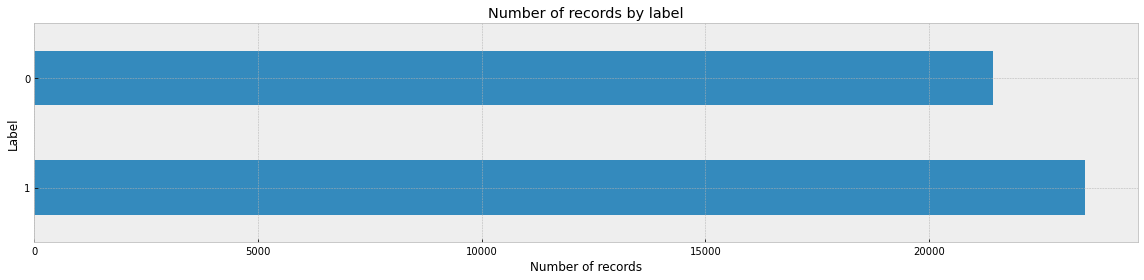

In [5]:
df["label"].value_counts().plot(kind='barh', figsize=(16,4))
plt.title("Number of records by label")
plt.xlabel("Number of records")
plt.ylabel("Label")
plt.tight_layout()
plt.show()

In [6]:
df.isna().sum()

title      0
text       0
subject    0
date       0
label      0
dtype: int64

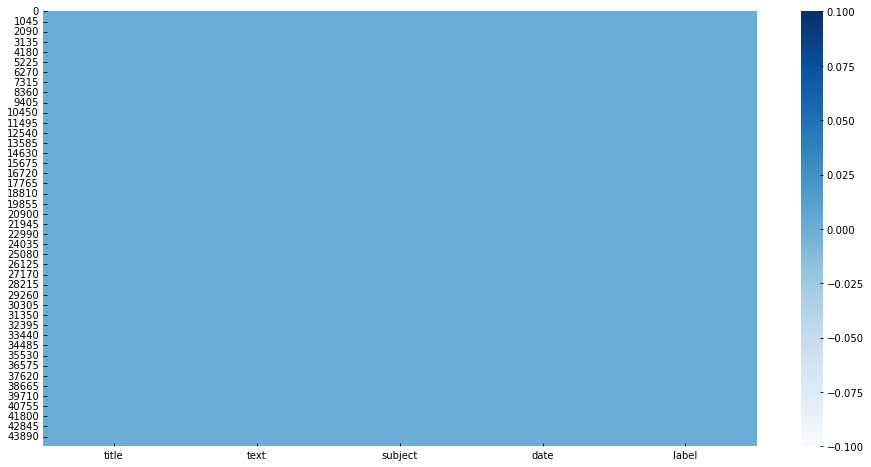

In [7]:
sns.heatmap(df.isnull(), cmap='Blues')
plt.show()

* In cases where a value is missing in one column, it becomes apparent that the corresponding data in the other column remains intact. While we typically delete rows when all the values are empty, this unique scenario allows us to preserve the rows due to the potential compensatory information present in the other column. Thus, the availability of additional data mitigates the impact of the missing value and ensures that we can still extract valuable insights from the remaining information. 

In [8]:
# filling mising value
df = df.fillna(" ")

In [9]:
df["corpus"] = df["title"]  + df["text"]
df = df.drop(["title", "text"], axis=1)

# make sentence lower case
df["corpus"] = df["corpus"].str.lower()

Sentence cleaning is a fundamental and crucial step in any natural language processing (NLP) problem. It involves several important tasks, including word tokenization, removal of special characters, stop words elimination, and lemmatization.

During word tokenization, the sentence is split into individual words, allowing us to analyze and process each word separately. Special characters, such as punctuation marks and symbols, are removed to focus on the meaningful content of the text.

Stop words, which are commonly used words with little semantic value (e.g., "the," "is," "and"), are eliminated to reduce noise and improve the quality of the text representation. Removing stop words helps to extract more relevant and meaningful information from the text.

Additionally, lemmatization is applied to convert words into their base or dictionary form (lemma). This process reduces word variations and ensures consistent representation. For example, words like "running," "ran," and "runs" would be transformed to their base form "run."

By performing these cleaning steps, we can preprocess the text data and create a cleaner and more consistent representation, which is essential for various NLP tasks such as text classification, information retrieval, sentiment analysis, and machine translation.

Overall, sentence cleaning plays a vital role in enhancing the quality and effectiveness of NLP models by reducing noise, improving text representation, and facilitating better understanding and analysis of the text data.

In [10]:
lemmatizer = WordNetLemmatizer()

def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return None


def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    lem_text = []
    for word in text:
        lem_text.append(lemmatizer.lemmatize(word))
    return lem_text

def clean_corpus(df):
    df_len = df.shape[0]
    for idx, row in df.iterrows():
        # remove punctuations and keep only word or spaces
        removed_spc_char_corpus = re.sub(r'[^\w\s]','', row["corpus"])

        # tokenize corpus
        corpus_token = nltk.word_tokenize(removed_spc_char_corpus)

        # remove stop words
        stop_words = set(stopwords.words("english"))
        corpus_stop_wrd_remvd = [word for word in corpus_token if word not in stop_words]

        # lemmatize words
        cleaned_corpus = lemmatize_text(corpus_stop_wrd_remvd)

#         cleaned_corpus = lemmatize_text(nltk.pos_tag(corpus_stop_wrd_remvd))
        
        # join words back
        cleaned_corpus = ' '.join(cleaned_corpus)
        df.loc[idx, "corpus"] = cleaned_corpus
        
        if not idx%2000:
            print(f"{idx}/{df_len}")
    
    return df
    

In [11]:
# clean the corpus
df = clean_corpus(df)

0/44898
2000/44898
4000/44898
6000/44898
8000/44898
10000/44898
12000/44898
14000/44898
16000/44898
18000/44898
20000/44898
22000/44898
24000/44898
26000/44898
28000/44898
30000/44898
32000/44898
34000/44898
36000/44898
38000/44898
40000/44898
42000/44898
44000/44898


### Visual analysis

In [12]:
lebel_0_corpus = " ".join(df.loc[df["label"]==0, "corpus"].tolist())
lebel_1_corpus = " ".join(df.loc[df["label"]==1, "corpus"].tolist())

In [13]:
stop_word_for_label_1 = nltk.word_tokenize(lebel_0_corpus)
stop_word_for_label_0 = nltk.word_tokenize(lebel_1_corpus)

* Word Cloud for Reliable News

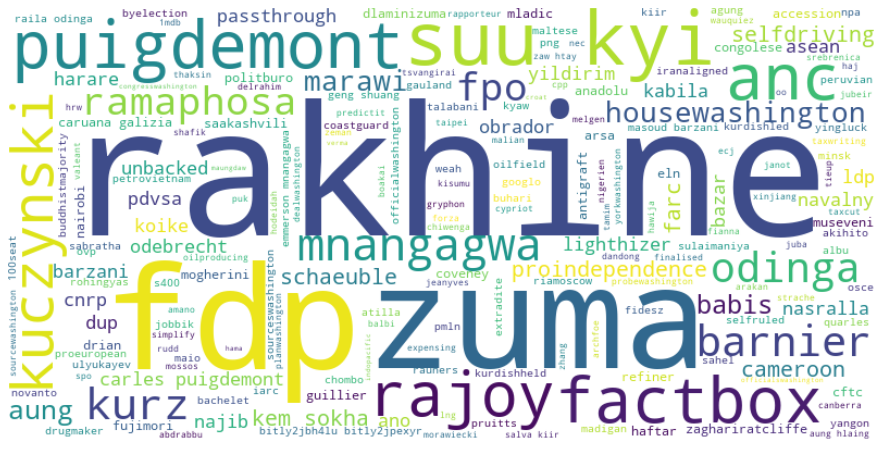

In [14]:
wordcloud = WordCloud(width=800, height=400, background_color='white',
                     stopwords=stop_word_for_label_0).generate(" ".join(df.loc[df["label"]==0, "corpus"].tolist()))

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

* Word Cloud for Unreliable News

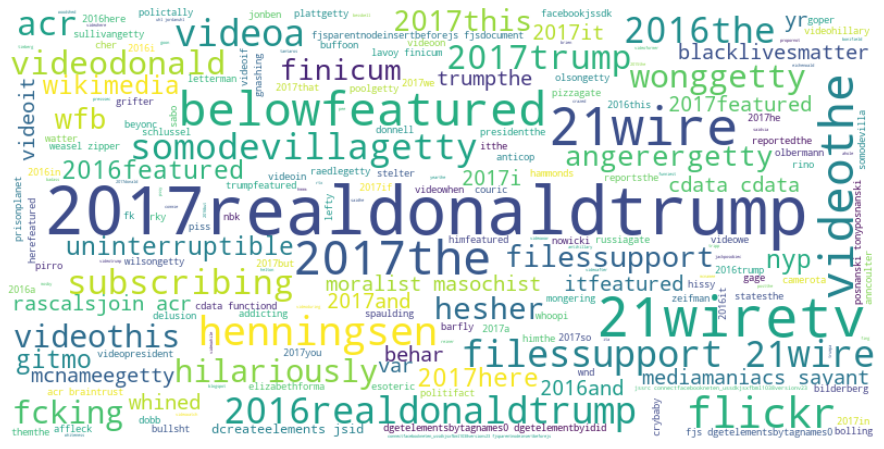

In [15]:
wordcloud = WordCloud(width=800, height=400, background_color='white',
                     stopwords=stop_word_for_label_1).generate(" ".join(df.loc[df["label"]==1, "corpus"].tolist()))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## Model Building

In [16]:
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import recall_score, precision_score, f1_score, confusion_matrix, accuracy_score

In [17]:
X_train = df['corpus']
Y_train = df['label']

#### Machine Learning Models

In [18]:
# find all unique word vector
count_vectorizer = CountVectorizer(max_features=500)
count_vectorizer.fit(X_train)

# calculate frequency for each word in document
freq_term_matrix = count_vectorizer.transform(X_train)

# calculate inverse term frequency
tfidf = TfidfTransformer(norm="l2")
tfidf.fit(freq_term_matrix)
tf_idf_matrix = tfidf.transform(freq_term_matrix)

In [19]:
models = {
    "RandomForest": RandomForestRegressor(n_estimators=100,max_depth=10, random_state=123),
    "LR" : LogisticRegression(),
    "naive_bayes" : GaussianNB(),
    "KNN" : KNeighborsClassifier()}

In [20]:
# split in train test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(tf_idf_matrix, Y_train,test_size=0.3, random_state=0)

Metric - RandomForest
Recall         :  0.990521997453671
Precision      :  0.9676616915422885
F1 score       :  0.9789584061516953
Accuracy score :  0.9776540460282108

Metric - LR
Recall         :  0.9766586504456076
Precision      :  0.9830556742132992
F1 score       :  0.9798467215441385
Accuracy score :  0.9789161098737936

Metric - naive_bayes
Recall         :  0.8987126892063941
Precision      :  0.938543359432708
F1 score       :  0.9181962711374476
Accuracy score :  0.9159613956941351

Metric - KNN
Recall         :  0.9067760645070024
Precision      :  0.8019517077442763
F1 score       :  0.8511485858451734
Accuracy score :  0.8335560504825539



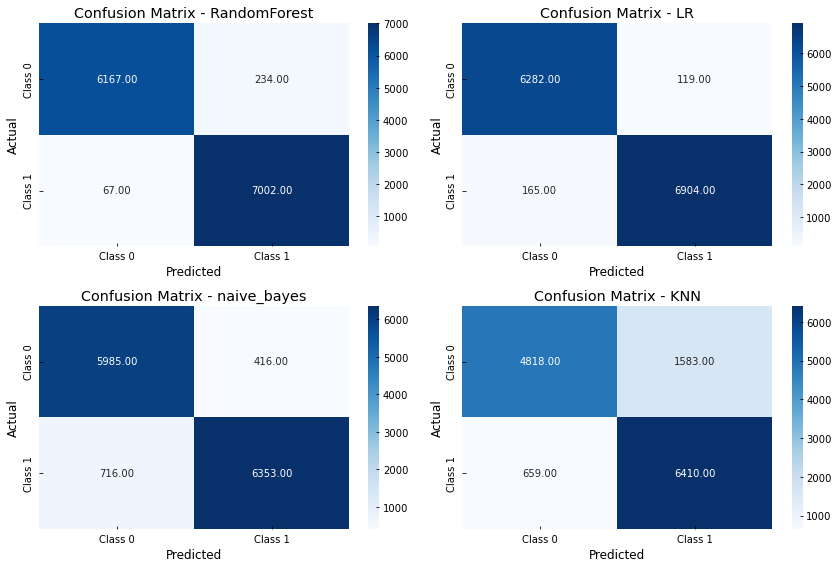

In [21]:
num_models = len(models)
num_rows = (num_models + 1) // 2  # +1 to accommodate uneven number of models
num_columns = 2

# Set the figure size
fig = plt.figure(figsize=(12, 8))

# create model dir if not exixts
if not os.path.exists("models"):
    os.mkdir("models")
    
for idx, model in enumerate(models):
    models[model].fit(X_train.toarray(), y_train)
    # save model
    dump(models[model], f"models/{model}.pkl")
    
    y_prediction = models[model].predict(X_test.toarray())
    y_prediction = np.where(y_prediction>0.5, 1, 0)

    print("Metric - {}".format(model))
    print("Recall         : ", recall_score(y_pred=y_prediction, y_true=y_test))
    print("Precision      : ", precision_score(y_pred=y_prediction, y_true=y_test))
    print("F1 score       : ", f1_score(y_pred=y_prediction, y_true=y_test))
    print("Accuracy score : ", accuracy_score(y_pred=y_prediction, y_true=y_test))
    print("")
    
    cm = confusion_matrix(y_pred=y_prediction, y_true=y_test)
    
    # Plot the confusion matrix
    ax = fig.add_subplot(num_rows, num_columns, idx + 1)
    sns.heatmap(cm, cmap='Blues',ax=ax, annot=True, annot_kws={"fontsize": 10, "ha": "center"}, fmt=".2f")
    ax.set_title("Confusion Matrix - {}".format(model))
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
    ax.set_xticks([0.5, 1.5])
    ax.set_yticks([0.5, 1.5])
    ax.tick_params(pad=5)
    ax.set_xticklabels(["Class 0", "Class 1"])
    ax.set_yticklabels(["Class 0", "Class 1"])
    ax.grid(False)

plt.tight_layout()
plt.show()

#### Deeplearning Models

In [22]:
from tensorflow.keras.layers import Embedding,LSTM,Dense,Dropout, Input, Bidirectional, GRU
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential 
from tensorflow.keras.preprocessing.text import one_hot
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
import tensorflow as tf

2023-09-24 17:25:21.378890: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [23]:
X, y = df["corpus"], df["label"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

corpus = X_train.tolist()
corpus_test = X_test.tolist()

vocab_size = 2000


In [24]:
# one hot encode corpus
onehot_corpus = [one_hot(words,vocab_size)for words in corpus]
onehot_corpus_test = [one_hot(words,vocab_size)for words in corpus_test]

# Padding Sentences to make them of same size
embedded_docs = pad_sequences(onehot_corpus,padding='post',maxlen=50)
embedded_docs_test = pad_sequences(onehot_corpus_test,padding='post',maxlen=50)

# convert docs to numpy array
X_train = np.array(embedded_docs)
y_train = np.array(y_train)
X_test = np.array(embedded_docs_test)
y_test = np.array(y_test)

In [25]:
# define model architecture
#We have used embedding layers with LSTM
model = Sequential()
model.add(Embedding(vocab_size,100,input_length=50,name="input"))
model.add(Dropout(0.2))
model.add(LSTM(100))
model.add(Dropout(0.2))
model.add(Dense(32,activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(1,activation='sigmoid', name="target"), )
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['binary_crossentropy'])
print(model.summary())

2023-09-24 17:25:34.652049: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (Embedding)           (None, 50, 100)           200000    
                                                                 
 dropout (Dropout)           (None, 50, 100)           0         
                                                                 
 lstm (LSTM)                 (None, 100)               80400     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense (Dense)               (None, 32)                3232      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 target (Dense)              (None, 1)                 3

In [26]:
def bootstrap_generator(batch_size):
    while True:
        batch_idx = np.random.choice(np.array(X_train).shape[0], batch_size)
    
        yield ({"input_input": np.array(X_train)[batch_idx]},
               {"target": np.array(y_train)[batch_idx]})

In [27]:
model_name="LSTM"
modelCheckpoint = ModelCheckpoint(filepath=f"models/{model_name}.h5", monitor='loss', mode='min', save_best_only=True, verbose=1)
earlystopping = EarlyStopping(monitor="loss", patience=10, verbose=1, restore_best_weights=True)


batch_size=512
model.fit(bootstrap_generator(batch_size), epochs=100, steps_per_epoch=10, callbacks=[modelCheckpoint, earlystopping])



Epoch 1/100
10/10 [==============================] - ETA: 0s - loss: 0.6728 - binary_crossentropy: 0.6728
Epoch 1: loss improved from inf to 0.67284, saving model to models/LSTM.h5
10/10 [==============================] - 4s 173ms/step - loss: 0.6728 - binary_crossentropy: 0.6728
Epoch 2/100
10/10 [==============================] - ETA: 0s - loss: 0.4533 - binary_crossentropy: 0.4533
Epoch 2: loss improved from 0.67284 to 0.45326, saving model to models/LSTM.h5
10/10 [==============================] - 2s 176ms/step - loss: 0.4533 - binary_crossentropy: 0.4533
Epoch 3/100
10/10 [==============================] - ETA: 0s - loss: 0.3103 - binary_crossentropy: 0.3103
Epoch 3: loss improved from 0.45326 to 0.31031, saving model to models/LSTM.h5
10/10 [==============================] - 2s 172ms/step - loss: 0.3103 - binary_crossentropy: 0.3103
Epoch 4/100
10/10 [==============================] - ETA: 0s - loss: 0.2401 - binary_crossentropy: 0.2401
Epoch 4: loss improved from 0.31031 to 0.24

10/10 [==============================] - ETA: 0s - loss: 0.0635 - binary_crossentropy: 0.0635
Epoch 31: loss improved from 0.06443 to 0.06354, saving model to models/LSTM.h5
10/10 [==============================] - 2s 199ms/step - loss: 0.0635 - binary_crossentropy: 0.0635
Epoch 32/100
10/10 [==============================] - ETA: 0s - loss: 0.0589 - binary_crossentropy: 0.0589
Epoch 32: loss improved from 0.06354 to 0.05892, saving model to models/LSTM.h5
10/10 [==============================] - 2s 222ms/step - loss: 0.0589 - binary_crossentropy: 0.0589
Epoch 33/100
10/10 [==============================] - ETA: 0s - loss: 0.0621 - binary_crossentropy: 0.0621
Epoch 33: loss did not improve from 0.05892
10/10 [==============================] - 2s 204ms/step - loss: 0.0621 - binary_crossentropy: 0.0621
Epoch 34/100
10/10 [==============================] - ETA: 0s - loss: 0.0599 - binary_crossentropy: 0.0599
Epoch 34: loss did not improve from 0.05892
10/10 [==============================

In [28]:
# predict output
y_prediction = model.predict(X_test)

351/351 [==============================] - 4s 9ms/step


Metric - Sequential NN
Recall         :  0.9595425059747354
Precision      :  0.9583972719522592
F1 score       :  0.958969547044272
Accuracy score :  0.9571492204899777



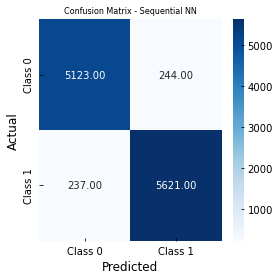

In [29]:
f, ax = plt.subplots(1,1, figsize=(4,4))
y_prediction = np.where(y_prediction>0.5, 1, 0)
print("Metric - {}".format("Sequential NN"))
print("Recall         : ", recall_score(y_pred=y_prediction, y_true=y_test))
print("Precision      : ", precision_score(y_pred=y_prediction, y_true=y_test))
print("F1 score       : ", f1_score(y_pred=y_prediction, y_true=y_test))
print("Accuracy score : ", accuracy_score(y_pred=y_prediction, y_true=y_test))

print("")

cm = confusion_matrix(y_pred=y_prediction, y_true=y_test)

# Plot the confusion matrix
sns.heatmap(cm, cmap='Blues', annot=True, annot_kws={"fontsize": 10, "ha": "center"}, fmt=".2f")
ax.set_title("Confusion Matrix - {}".format("Sequential NN"), fontsize=8)
ax.set_xlabel("Predicted")
ax.set_ylabel("Actual")
ax.set_xticks([0.5, 1.5])
ax.set_yticks([0.5, 1.5])
ax.tick_params(pad=5)
ax.set_xticklabels(["Class 0", "Class 1"])
ax.set_yticklabels(["Class 0", "Class 1"])
ax.grid(False)
plt.tight_layout()
plt.show()

## Load Specific model for check

In [30]:
model = load("models/LR.pkl")

In [31]:
def check_news():
    news = input('Submit the news\n')

    # perform cleaning
    removed_spc_char_corpus = re.sub(r'[^\w\s]','', news)

    # tokenize corpus
    corpus_token = nltk.word_tokenize(removed_spc_char_corpus)

    # remove stop words
    stop_words = set(stopwords.words("english"))
    corpus_stop_wrd_remvd = [word for word in corpus_token if word not in stop_words]

    # lemmatize words
    cleaned_corpus = lemmatize_text(corpus_stop_wrd_remvd)


    # join words back
    cleaned_corpus = ' '.join(cleaned_corpus)
    
    print("cleaned", cleaned_corpus)
    # calculate frequency for each word in document
    freq_term_matrix = count_vectorizer.transform([cleaned_corpus])

    
    # calculate inverse term frequency
    tf_idf_matrix = tfidf.transform(freq_term_matrix)
    
    #calculate probability
    probability = model.predict(tf_idf_matrix.reshape(1,-1))* 100
    probability = round(probability[0], 2)

    return cleaned_corpus, probability

cleaned_corpus, probability = check_news()

print(f"\nProbability for this news being fake is     : {probability}%")

Submit the news
WASHINGTON (Reuters) - The special counsel investigation of links between Russia and President Trump‚Äôs 2016 election campaign should continue without interference in 2018, despite calls from some Trump administration allies and Republican lawmakers to shut it down, a prominent Republican senator said on Sunday. Lindsey Graham, who serves on the Senate armed forces and judiciary committees, said Department of Justice Special Counsel Robert Mueller needs to carry on with his Russia investigation without political interference. ‚ÄúThis investigation will go forward. It will be an investigation conducted without political influence,‚Äù Graham said on CBS‚Äôs Face the Nation news program. ‚ÄúAnd we all need to let Mr. Mueller do his job. I think he‚Äôs the right guy at the right time.‚Äù  The question of how Russia may have interfered in the election, and how Trump‚Äôs campaign may have had links with or co-ordinated any such effort, has loomed over the White House since T

# Loading all ML models to check for Fake News

In [32]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
#from sklearn.externals import joblib
import joblib

# Load all models
model_names = ["RandomForest.pkl", "LR.pkl", "KNN.pkl", "naive_bayes.pkl"]
models = {}

for model_name in model_names:
    model = joblib.load(f"models/{model_name}")
    models[model_name] = model

def check_news():
    news = input('Submit the news\n')

    # perform cleaning
    removed_spc_char_corpus = re.sub(r'[^\w\s]','', news)

    # tokenize corpus
    corpus_token = nltk.word_tokenize(removed_spc_char_corpus)

    # remove stop words
    stop_words = set(stopwords.words("english"))
    corpus_stop_wrd_remvd = [word for word in corpus_token if word not in stop_words]

    # lemmatize words
    cleaned_corpus = lemmatize_text(corpus_stop_wrd_remvd)

    # join words back
    cleaned_corpus = ' '.join(cleaned_corpus)
    
    print("cleaned", cleaned_corpus)
    # calculate frequency for each word in document
    freq_term_matrix = count_vectorizer.transform([cleaned_corpus])

    # calculate inverse term frequency
    tf_idf_matrix = tfidf.transform(freq_term_matrix)

    # calculate probabilities for all models
    probabilities = {}
    for model_name, model in models.items():
        # Convert the sparse matrix to a dense array
        dense_tf_idf_matrix = tf_idf_matrix.toarray()
        probability = model.predict(dense_tf_idf_matrix) * 100
        probability = round(probability[0], 2)
        probabilities[model_name] = probability

    # Calculate the average probability
    avg_probability = sum(probabilities.values()) / len(probabilities)

    return cleaned_corpus, avg_probability

cleaned_corpus, avg_probability = check_news()

print(f"\nAverage Probability for this news being fake is: {avg_probability}%")


Submit the news
WASHINGTON (Reuters) - The special counsel investigation of links between Russia and President Trump‚Äôs 2016 election campaign should continue without interference in 2018, despite calls from some Trump administration allies and Republican lawmakers to shut it down, a prominent Republican senator said on Sunday. Lindsey Graham, who serves on the Senate armed forces and judiciary committees, said Department of Justice Special Counsel Robert Mueller needs to carry on with his Russia investigation without political interference. ‚ÄúThis investigation will go forward. It will be an investigation conducted without political influence,‚Äù Graham said on CBS‚Äôs Face the Nation news program. ‚ÄúAnd we all need to let Mr. Mueller do his job. I think he‚Äôs the right guy at the right time.‚Äù  The question of how Russia may have interfered in the election, and how Trump‚Äôs campaign may have had links with or co-ordinated any such effort, has loomed over the White House since T